In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from pyntcloud import PyntCloud
from modelnet import ModelNet, rotate, jitter
import utils
import time

/home/marcus/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Load ModelNet 40

In [2]:
# Load the ModelNet data loader
modelnet = ModelNet(shuffle=True)

## Define the network with tensorflow

![PointNet](PointNet-Architecture.png)

In [3]:
# Point cloud placeholder -> [batch_size x num_points x 3]
points = tf.placeholder(tf.float32, [None, modelnet.num_points, 3])
labels = tf.placeholder(tf.float32, [None, modelnet.num_categories])

def transformation_network(inputs, output_size, init_identity=False):
    # Increase num features -> MLP(64, 128, 1024)
    feat = tf.layers.conv1d(inputs, filters=64, kernel_size=1, strides=1)   # [batch_size x num_points x 64]
    feat = tf.contrib.layers.batch_norm(feat)
    feat = tf.layers.conv1d(feat, filters=128, kernel_size=1, strides=1)  # [batch_size x num_points x 128]
    feat = tf.contrib.layers.batch_norm(feat)
    feat = tf.layers.conv1d(feat, filters=1024, kernel_size=1, strides=1) # [batch_size x num_points x 1024]
    feat = tf.contrib.layers.batch_norm(feat)

    # Extract global features -> maxpool
    feat = tf.reduce_max(feat, 1) # [batch_size x 1024]

    # Generate predictions -> FC(512, 256, num_categories)
    feat = tf.layers.dense(feat, units=512, activation=tf.nn.relu) # [batch_size x 512]
    feat = tf.contrib.layers.batch_norm(feat)
    feat = tf.layers.dense(feat, units=256, activation=tf.nn.relu) # [batch_size x 256]
    feat = tf.contrib.layers.batch_norm(feat)
    return tf.layers.dense(feat,
                           units=output_size,
                           activation=None,
                           kernel_initializer=(tf.initializers.identity if init_identity else None)) # [batch_size x output_size]

# Transform input
transformation_matrix = tf.reshape(transformation_network(points, 3 * 3, init_identity=True), [-1, 3, 3])
feat = tf.matmul(points, transformation_matrix)

# Points to features -> MLP(64, 64)
feat = tf.layers.conv1d(feat, filters=64, kernel_size=1, strides=1) # [batch_size x num_points x 64]
feat = tf.contrib.layers.batch_norm(feat)
feat = tf.layers.conv1d(feat, filters=64, kernel_size=1, strides=1)   # [batch_size x num_points x 64]
feat = tf.contrib.layers.batch_norm(feat)

# Transform features
transformation_matrix = tf.reshape(transformation_network(feat, 64 * 64, init_identity=True), [-1, 64, 64])

# Add Frobenious norm of feature transform matrix to loss
Lreg = tf.reduce_sum(tf.norm(tf.eye(64) - tf.matmul(transformation_matrix, transformation_matrix, transpose_b=True), axis=[1, 2]))

feat = tf.matmul(feat, transformation_matrix, )

# Features to classification
feat = transformation_network(feat, modelnet.num_categories)
feat = tf.layers.dropout(feat, rate=0.3) # Dropout with keep rate 0.7 = 1.0 - 0.3

# Cross entropy softmax loss
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=feat, labels=labels)) + Lreg * 0.001

# Get predicted classes
predictions = tf.argmax(tf.nn.softmax(feat), axis=1)

# Calculate accuracy
correct_labels = tf.equal(predictions, tf.argmax(labels, axis=1))
accuracy = tf.reduce_mean(tf.cast(correct_labels, tf.float32))

In [ ]:
# Placeholder for learning rate (used in training loop)
learning_rate = tf.placeholder(tf.float32, [], name="learning_rate")

# Initialize AdamOptimizer
optim = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

# Create session
config = tf.ConfigProto(device_count = {'GPU': 0}) # Force CPU
sess = tf.InteractiveSession(config=config)
tf.global_variables_initializer().run()

### Training loop

In [ ]:
from ipywidgets import Label, Box
from IPython.display import display

label = Label("")
display(Box([label]))

# Make batches to train
batch_size = 64
current_epoch = 122
current_learning_rate = 0.001
current_loss = float("nan")
current_test_accuracy = float("nan")
num_iter = 0
start_time = time.time()
epoch_time = 0

# Try to load model file if epoch is specified
if current_epoch != 0:
    saver = tf.train.import_meta_graph("models/PointNet_Vanilla-%i.meta" % current_epoch)
    saver.restore(sess, tf.train.latest_checkpoint("./models"))
    current_learning_rate /= np.power(2, current_epoch // 20)
else:
    saver = tf.train.Saver()

while True:
    # If epoch of training data is complete
    if modelnet.train.is_epoch_complete():
        # Measure time
        epoch_time = time.time() - start_time
        start_time = time.time()
        
        # Increase epoch count
        current_epoch += 1
        current_loss /= num_iter
        num_iter = 0
        
        # Every 20th epoch, halve the learning rate
        # and calculate accuracy on the test set
        if current_epoch % 20 == 0:
            # Save the model
            saver.save(sess, "models/PointNet_Vanilla", global_step=current_epoch)
            
            # Halve the learning rate
            current_learning_rate /= 2.0
            
            # Calculate accuracy on test set
            acc_values = []
            while True:
                batch_points, batch_labels = modelnet.test.next_batch(batch_size)
                complete = modelnet.test.is_epoch_complete()
                if complete:
                    batch_points = batch_points[:-modelnet.test._index_in_epoch]
                    batch_labels = batch_labels[:-modelnet.test._index_in_epoch]
                acc_values.append(sess.run([accuracy], feed_dict={points: batch_points, labels: batch_labels}))
                if complete:
                    break
            current_test_accuracy = np.mean(acc_values)
            
        # Display training status
        label.value = "Epoch %i; Time: %im %is; Loss: %f; Learning rate: %f; Test accuracy: %f" % \
                      (current_epoch, epoch_time // 60, epoch_time % 60, current_loss, current_learning_rate, current_test_accuracy)
    
    # Get next batch
    batch_points, batch_labels = modelnet.train.next_batch(batch_size)
    
    # Rotate 10% of the time
    if np.random.rand() < 0.1:
        batch_points = rotate(batch_points, np.pi * np.random.choice([1.0 / 2.0, 1.0, 3.0 / 2.0])) # np.random.uniform(-0.01, 0.01))
    
    # Jitter 25% of the time
    if np.random.rand() < 0.25:
        batch_points = jitter(batch_points, 0.0, 0.02)
    
    # Do training
    current_loss += sess.run([optim, loss], feed_dict={learning_rate: current_learning_rate,
                                                       points: batch_points,
                                                       labels: batch_labels})[1]
    num_iter += 1

A Jupyter Widget

#### Best result
---

### Loss graph

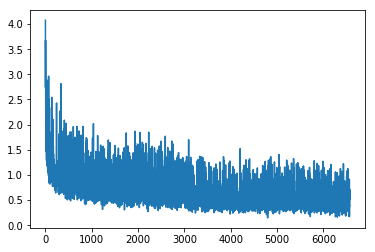

In [9]:
plt.plot(loss_values)
plt.show()